In this Notebook, we used Amy's code to reproduce her results.  That said, we encountered a few interesting elements along the way, which will be called out in Markdown cells like this one.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2025-06-14 14:08:27.035511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749910107.065111     567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749910107.074003     567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.18.0


The error message above was the first interesting element \- we weren't able to used TPUs or GPUs for parallel processing, which further down will mean that it takes several hours to train the model, vs just a few minutes for Amy.  We tried a few options but none of them worked, so they aren't captured here.


In the cell below, we see our second divergence from Amy's code in that we change the batch size from her 16 to our 25.  This is because the batch size of 16 was creating an error further down when we visualized the 25 sample images, and even further down it blocked the training of the model.  Changing the batch size to 25 fixed all of this.

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [3]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://kds-74b0f210fed2aea8480fadbe9cade6f7d44e40e2d28b9552698dd9b7/chest_xray/train/NORMAL/IM-0377-0001.jpeg'
b'gs://kds-74b0f210fed2aea8480fadbe9cade6f7d44e40e2d28b9552698dd9b7/chest_xray/train/PNEUMONIA/person305_bacteria_1435.jpeg'
b'gs://kds-74b0f210fed2aea8480fadbe9cade6f7d44e40e2d28b9552698dd9b7/chest_xray/train/PNEUMONIA/person585_bacteria_2414.jpeg'
b'gs://kds-74b0f210fed2aea8480fadbe9cade6f7d44e40e2d28b9552698dd9b7/chest_xray/train/PNEUMONIA/person1393_virus_2396.jpeg'
b'gs://kds-74b0f210fed2aea8480fadbe9cade6f7d44e40e2d28b9552698dd9b7/chest_xray/train/PNEUMONIA/person458_bacteria_1953.jpeg'


2025-06-14 14:08:33.502563: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Here we get the error again due to not being able to use the TPUs, but it doesn't have any effect downstream except for dramatically slowing down the training time.

In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [7]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

Below this are the 25 images. This is where having a batch size of 16 was problematic, and the batch size of 25 images solves that.

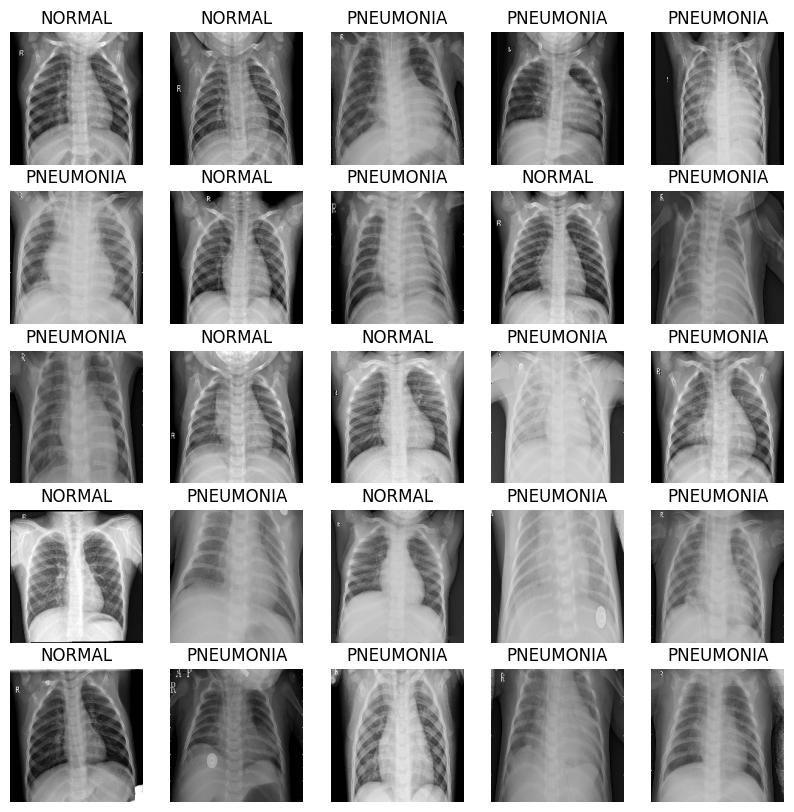

In [17]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.03865396])

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


Note that our weights here aren't 100% exactly the same ones that amy found, but that level of variation is fully within expected tolerances here.

In [23]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
# Convert boolean labels to integers
def fix_labels(image, label):
    label = tf.cast(label, tf.int32)  # Converts True->1, False->0
    return image, label

# Apply to both datasets
train_ds = train_ds.map(fix_labels)
val_ds = val_ds.map(fix_labels)

Below we can see the first meaningful impact of having different Batch sizes from Amy, as well as not having 8 parallel processes like she does:  Each of our epochs has to run 167 batches of 25 images, wherease her epochs only ran 32 batches of 16 images.  This made of compute time significantly higher.



In [25]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.7060 - loss: 0.5228 - precision: 0.9136 - recall: 0.6657 - val_accuracy: 0.7571 - val_loss: 0.5546 - val_precision: 0.7571 - val_recall: 1.0000
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 163s 975ms/step - accuracy: 0.9108 - loss: 0.2094 - precision: 0.9771 - recall: 0.9029 - val_accuracy: 0.7561 - val_loss: 0.9390 - val_precision: 0.7561 - val_recall: 1.0000
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9305 - loss: 0.1656 - precision: 0.9839 - recall: 0.9220 - val_accuracy: 0.7551 - val_loss: 1.8435 - val_precision: 0.7551 - val_recall: 1.0000
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 164s 984ms/step - accuracy: 0.9277 - loss: 0.1819 - precision: 0.9789 - recall: 0.9247 - val_accuracy: 0.7580 - val_loss: 1.9954 - val_precision: 0.7580 - val_recall: 1.0000
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 164s 980ms/step - accuracy: 0.9423 - loss: 0.1508 - precision: 0.9842 - recall: 0.9376 - val_accuracy: 0.8927 

Our results:
**recall: 0.9855** - **precision: 0.9981** - **accuracy: 0.9879** - **loss: 0.0347** - val_recall: 0.9897 - **val_precision: 0.9922** - **val_accuracy: 0.9863** - **val_loss: 0.0357** -  


Amy's original results:
recall: 0.9709 - precision: 0.9943 - accuracy: 0.9741 - loss: 0.0801 - **val_recall: 0.9987** - val_precision: 0.9494 - val_accuracy: 0.9600 - val_loss: 0.098

We're generally in the same ballpark as Amy, but it is interesting to see that our scores are geneally just a little better than hers, except in validation recall.  How will that hold up after fine-tuning the model?  Let's find out...

In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [27]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [28]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 164s 981ms/step - accuracy: 0.8800 - loss: 0.2984 - precision: 0.9562 - recall: 0.8786 - val_accuracy: 0.8888 - val_loss: 0.5080 - val_precision: 0.9911 - val_recall: 0.8605 - learning_rate: 0.0100
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 166s 992ms/step - accuracy: 0.9335 - loss: 0.1755 - precision: 0.9791 - recall: 0.9305 - val_accuracy: 0.9102 - val_loss: 0.2201 - val_precision: 0.9985 - val_recall: 0.8824 - learning_rate: 0.0089
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 163s 973ms/step - accuracy: 0.9389 - loss: 0.1673 - precision: 0.9814 - recall: 0.9343 - val_accuracy: 0.9337 - val_loss: 0.1591 - val_precision: 0.9586 - val_recall: 0.9537 - learning_rate: 0.0079
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 163s 974ms/step - accuracy: 0.9238 - loss: 0.1699 - precision: 0.9834 - recall: 0.9147 - val_accuracy: 0.9561 - val_loss: 0.1218 - val_precision: 0.9854 - val_recall: 0.9561 - learning_rate: 0.0071
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 162

Our Results: **recall: 0.9838** - **precision: 0.9975** - **accuracy: 0.9861** - **loss: 0.0471** - val_recall: 0.9678 - **val_precision: 0.9921** - **val_accuracy: 0.9698** - val_loss: 0.0802 - learning_rate: 7.0795e-04

Amy's Results: recall: 0.9799 - precision: 0.9966 - accuracy: 0.9827 - loss: 0.0480 - **val_recall: 0.9788** - val_precision: 0.9906 - val_accuracy: 0.9775 - **val_loss: 0.0655** - lr: 1.0000e-04

Here again our results are generally just a smidge better than Amy's, except for val_recall and val_loss.

We have only 3 differences with her process:

- We weren't able to use TPUs or GPUs
- We weren't able to use serial processing
- We changed our batch size to 25

The use of TPUs should not affect final results, but it may be possible that either the larger batch sizes or the lack of serial processing could be helping just a bit on our outcomes for now.


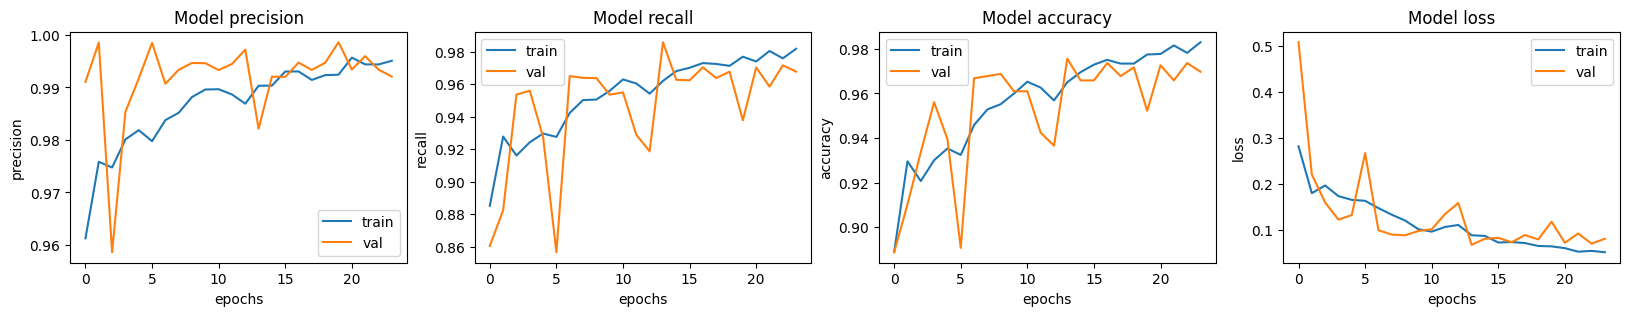

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, acc, prec, rec = model.evaluate(test_ds)



25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7723 - loss: 0.7499 - precision: 0.7356 - recall: 0.9985


Final Results:

Our Results: accuracy: 0.7723 \- **loss: 0.7499** \- **recall: 0.9985** \- precision: 0.7356

Amy's Results: **accuracy: 0.7869** - loss: 1.0298 - recall: 0.9974 - **precision: 0.7466**



Note that here, unlike in our training, our execution is not consistently better than Amy's across categories.

Amy's conclusions were the following:
1 - That since her model performed worse on test data than training data, it might be overfitting and that should be reduced.
2 - That some normal images are falsely identified as pneumonia, and that we should thus aim to increase precision.

This is what we will attempt to do in our next notebook.